# Supernovae simulation

## Imports

In [1]:
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
from importlib import import_module
import yaml
import pprint

## Choose parameters for the simulation

In [3]:
configFile = '../input/param_simulation_nb.yaml'
config = yaml.load(open(configFile),Loader=yaml.FullLoader) #configuration dict - mandatory for the run

In [4]:
pprint.pprint(config) 

{'Cosmology': {'H0': 72.0,
               'Model': 'w0waCDM',
               'Omega_l': 0.7,
               'Omega_m': 0.3,
               'w0': -1.0,
               'wa': 0.0},
 'Display_LC': {'display': False, 'time': 1},
 'Host Parameters': 'None',
 'Instrument': {'aerosol': False,
                'airmass': 1.2,
                'atmos': True,
                'atmos_dir': 'THROUGHPUTS_DIR',
                'name': 'LSST',
                'throughput_dir': 'LSST_THROUGHPUTS_BASELINE'},
 'Metric': 'sn_mafsim.sn_maf_simulation',
 'Multiprocessing': {'nproc': 1},
 'Observations': {'coadd': True,
                  'fieldtype': 'DD',
                  'filename': '/home/philippe/LSST/DB_Files/kraken_2026.db',
                  'season': 1},
 'Output': {'directory': 'Output_Simu', 'save': True},
 'Pixelisation': {'nside': 64},
 'ProductionID': 'DD_baseline2018a_Cosmo',
 'SN parameters': {'Id': 100,
                   'absmag': -19.0906,
                   'band': 'bessellB',
              

## dbFile choice

In [5]:
dbName = 'kraken_2026.db'
dbFile = '/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
version = opsimdb.opsimVersion

## Define slicer

In [6]:
slicer = slicers.HealpixSlicer(nside=config['Pixelisation']['nside'])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Prepare for run and run

In [7]:
fieldtype = config['Observations']['fieldtype'] #field type (WFD or DD)
propinfo, proptags = opsimdb.fetchPropInfo()
print('proptags and propinfo', proptags, propinfo)

sqlconstraint = opsimdb.createSQLWhere(fieldtype, proptags)
        
# Simulator instance
module = import_module(config['Metric'])
metric = module.SNMetric(
            config=config, coadd=config['Observations']['coadd'])

# metric bundle
mb = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
mbD = {0: mb}
outMAFDir = 'OutputMAF'
resultsDb = db.ResultsDb(outDir=outMAFDir)

mbg = metricBundles.MetricBundleGroup(mbD, opsimdb,
                                              outDir=outMAFDir, resultsDb=resultsDb)

mbg.runAll()

#this is to save metadata in a separate file
if metric.save_status:
    metric.simu.Finish()


proptags and propinfo {'WFD': [3], 'DD': [5], 'NES': [4]} {1: 'GalacticPlane', 2: 'SouthCelestialPole', 3: 'WideFastDeep', 4: 'NorthEclipticSpur', 5: 'DeepDrillingCosmology1'}
Creating output directory Output_Simu
Querying database SummaryAllProps with constraint proposalId = 5 for columns ['fieldRA', 'observationId', 'fiveSigmaDepth', 'observationStartMJD', 'seeingFwhmEff', 'filter', 'visitExposureTime', 'visitTime', 'night', 'numExposures', 'seeingFwhmGeom', 'fieldDec']
Found 112886 visits
Running:  [0]
Number of SN to simulate: 19
End of simulation 12.540071487426758
Number of SN to simulate: 19
End of simulation 11.918170690536499
Number of SN to simulate: 19
End of simulation 12.142726182937622
Number of SN to simulate: 19
End of simulation 11.616251230239868
Number of SN to simulate: 19
End of simulation 11.13736605644226
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [8]:
ls Output_Simu

LC_DD_baseline2018a_Cosmo.hdf5  Simu_DD_baseline2018a_Cosmo.hdf5


Two files are generated:
- Simu_*.hdf5: summary of the generated LC = list of parameters used for generation
- LC_*.hdf5: light curves 

## Output analysis

In [9]:
%matplotlib notebook
import matplotlib.pylab as plt
import h5py
import numpy as np
from astropy.table import Table

### Parameter file

In [10]:
paramFile = '{}/Simu_{}.hdf5'.format(config['Output']['directory'],config['ProductionID'])
f = h5py.File(paramFile, 'r')
print(f.keys(),len(f.keys()))
for i, key in enumerate(f.keys()):
    params = Table.read(paramFile, path=key)
    
# params is an astropy table
print(params[:10])
print(type(params),params.dtype)

<KeysViewHDF5 ['summary']> 1
SNID         Ra                Dec         ... fieldid n_lc_points survey_area
---- ------------------ ------------------ ... ------- ----------- -----------
 201 150.36235499999995 2.8364990000000003 ...     100          23         9.6
 202 150.36235499999995 2.8364990000000003 ...     100          26         9.6
 203 150.36235499999995 2.8364990000000003 ...     100          35         9.6
 204 150.36235499999995 2.8364990000000003 ...     100          34         9.6
 205 150.36235499999995 2.8364990000000003 ...     100          33         9.6
 206 150.36235499999995 2.8364990000000003 ...     100          52         9.6
 207 150.36235499999995 2.8364990000000003 ...     100          52         9.6
 208 150.36235499999995 2.8364990000000003 ...     100          51         9.6
 209 150.36235499999995 2.8364990000000003 ...     100          57         9.6
 210 150.36235499999995 2.8364990000000003 ...     100          57         9.6
<class 'astropy.table.t

In [11]:
def plotParameters(fieldname, fieldid, tab, season):
    """ Plot simulation parameters
    parameters ('X1', 'Color', 'DayMax', 'z')
    Input
    ---------
    fieldname: (DD or WFD)
    fieldid: (as given by OpSim)
    tab: recarray of parameters
    season: season

    Returns
    ---------
    Plot (x1,color,dayMax,z)
    """

    idx = tab['season'] == season
    sel = tab[idx]
    thesize = 15
    toplot = ['x1', 'color', 'daymax', 'z']
    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 9))
    title= '{} - fieldid {} - season {}'.format(fieldname,fieldid,season)
    fig.suptitle(title, fontsize=thesize)

    for i, var in enumerate(toplot):
        ix = int(i/2)
        iy = i % 2
        axis = ax[ix][iy]
        i#f var != 'z':
        axis.hist(sel[var],histtype='step') #bins=len(sel[var]))
        axis.set_xlabel(var, fontsize=20)
        axis.set_ylabel('Number of entries', fontsize=thesize)
        axis.tick_params(axis='x', labelsize=thesize)
        axis.tick_params(axis='y', labelsize=thesize)

fieldname
---------
       DD 100 SNID         Ra                Dec         ... fieldid n_lc_points survey_area
---- ------------------ ------------------ ... ------- ----------- -----------
 201 150.36235499999995 2.8364990000000003 ...     100          23         9.6
 202 150.36235499999995 2.8364990000000003 ...     100          26         9.6
 203 150.36235499999995 2.8364990000000003 ...     100          35         9.6
 204 150.36235499999995 2.8364990000000003 ...     100          34         9.6
 205 150.36235499999995 2.8364990000000003 ...     100          33         9.6
 206 150.36235499999995 2.8364990000000003 ...     100          52         9.6
 207 150.36235499999995 2.8364990000000003 ...     100          52         9.6
 208 150.36235499999995 2.8364990000000003 ...     100          51         9.6
 209 150.36235499999995 2.8364990000000003 ...     100          57         9.6
 210 150.36235499999995 2.8364990000000003 ...     100          57         9.6
 ...              

<IPython.core.display.Javascript object>


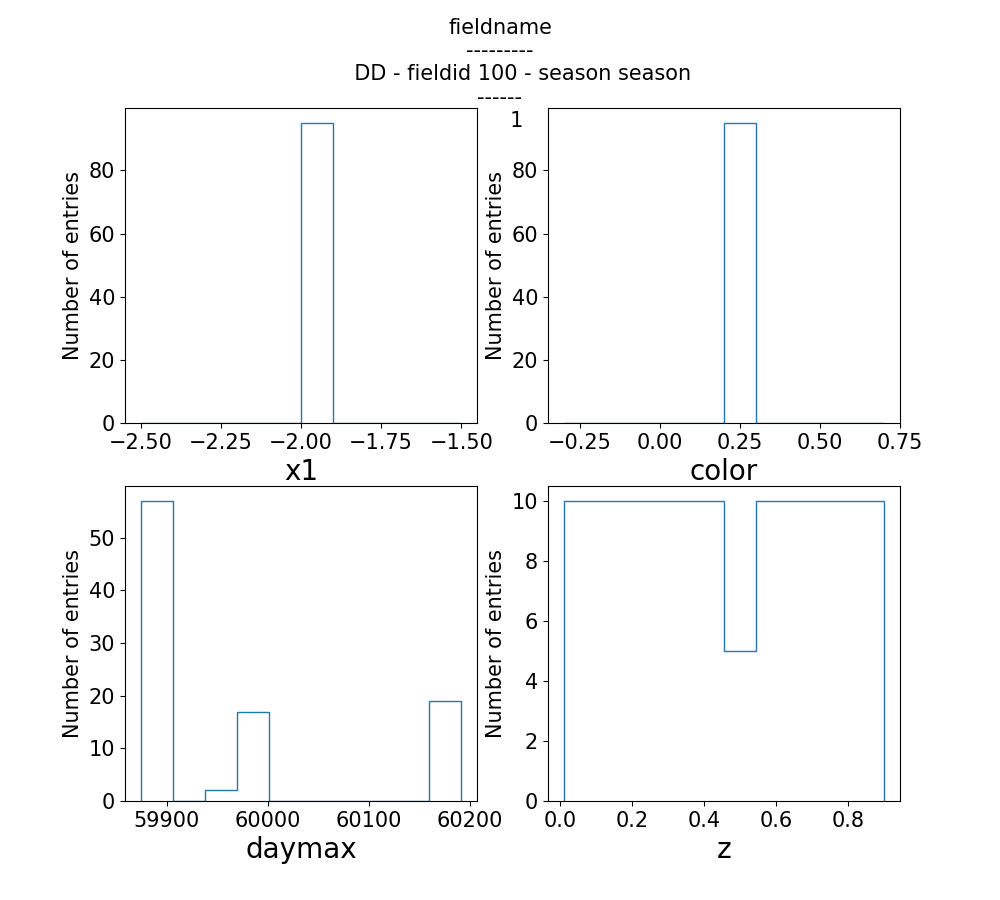

In [12]:
for fieldid in np.unique(params['fieldid']):
    idx = params['fieldid']==fieldid
    field = params[idx]
    fieldname = np.unique(field['fieldname'])
    season = np.unique(field['season'])
    print(fieldname,fieldid,field,season)
    plotParameters(fieldname,fieldid,field,season)
plt.show()

### Light curves

In [13]:
def plotLC(table,ax,band_id, inum = 0):
    fontsize = 10
    plt.yticks(size=fontsize)
    plt.xticks(size=fontsize)
    for band in 'ugrizy':
        i = band_id[band][0]
        j = band_id[band][1]
        #ax[i,j].set_yscale("log")
        idx = table['band'] == 'LSST::'+band
        sel = table[idx]
        #print('hello',band,inum,len(sel))
        #ax[band_id[band][0]][band_id[band][1]].errorbar(sel['time'],sel['mag'],yerr = sel['magerr'],color=colors[band])
        ax[i,j].errorbar(sel['time'],sel['flux_e'],yerr = sel['flux_e']/sel['snr_m5'],
                         markersize=200000.,color=colors[band],linewidth=1)
        if i > 1:
            ax[i,j].set_xlabel('MJD [day]',{'fontsize': fontsize})
        ax[i,j].set_ylabel('Flux [pe/sec]',{'fontsize': fontsize})
        ax[i,j].text(0.1, 0.9, band, horizontalalignment='center',
             verticalalignment='center', transform=ax[i,j].transAxes)


In [14]:
lcFile = '{}/LC_{}.hdf5'.format(config['Output']['directory'],config['ProductionID'])
f = h5py.File(lcFile, 'r')
print(f.keys(),len(f.keys()))

<KeysViewHDF5 ['lc_101', 'lc_102', 'lc_103', 'lc_104', 'lc_105', 'lc_106', 'lc_107', 'lc_108', 'lc_109', 'lc_110', 'lc_111', 'lc_112', 'lc_113', 'lc_114', 'lc_115', 'lc_116', 'lc_117', 'lc_118', 'lc_119', 'lc_120', 'lc_121', 'lc_122', 'lc_123', 'lc_124', 'lc_125', 'lc_126', 'lc_127', 'lc_128', 'lc_129', 'lc_130', 'lc_131', 'lc_132', 'lc_133', 'lc_134', 'lc_135', 'lc_136', 'lc_137', 'lc_138', 'lc_139', 'lc_140', 'lc_141', 'lc_142', 'lc_143', 'lc_144', 'lc_145', 'lc_146', 'lc_147', 'lc_148', 'lc_149', 'lc_150', 'lc_151', 'lc_152', 'lc_153', 'lc_154', 'lc_155', 'lc_156', 'lc_157', 'lc_158', 'lc_159', 'lc_160', 'lc_161', 'lc_162', 'lc_163', 'lc_164', 'lc_165', 'lc_166', 'lc_167', 'lc_168', 'lc_169', 'lc_170', 'lc_171', 'lc_172', 'lc_173', 'lc_174', 'lc_175', 'lc_176', 'lc_177', 'lc_178', 'lc_179', 'lc_180', 'lc_181', 'lc_182', 'lc_183', 'lc_184', 'lc_185', 'lc_186', 'lc_187', 'lc_188', 'lc_189', 'lc_190', 'lc_191', 'lc_192', 'lc_193', 'lc_194', 'lc_195']> 95


<IPython.core.display.Javascript object>


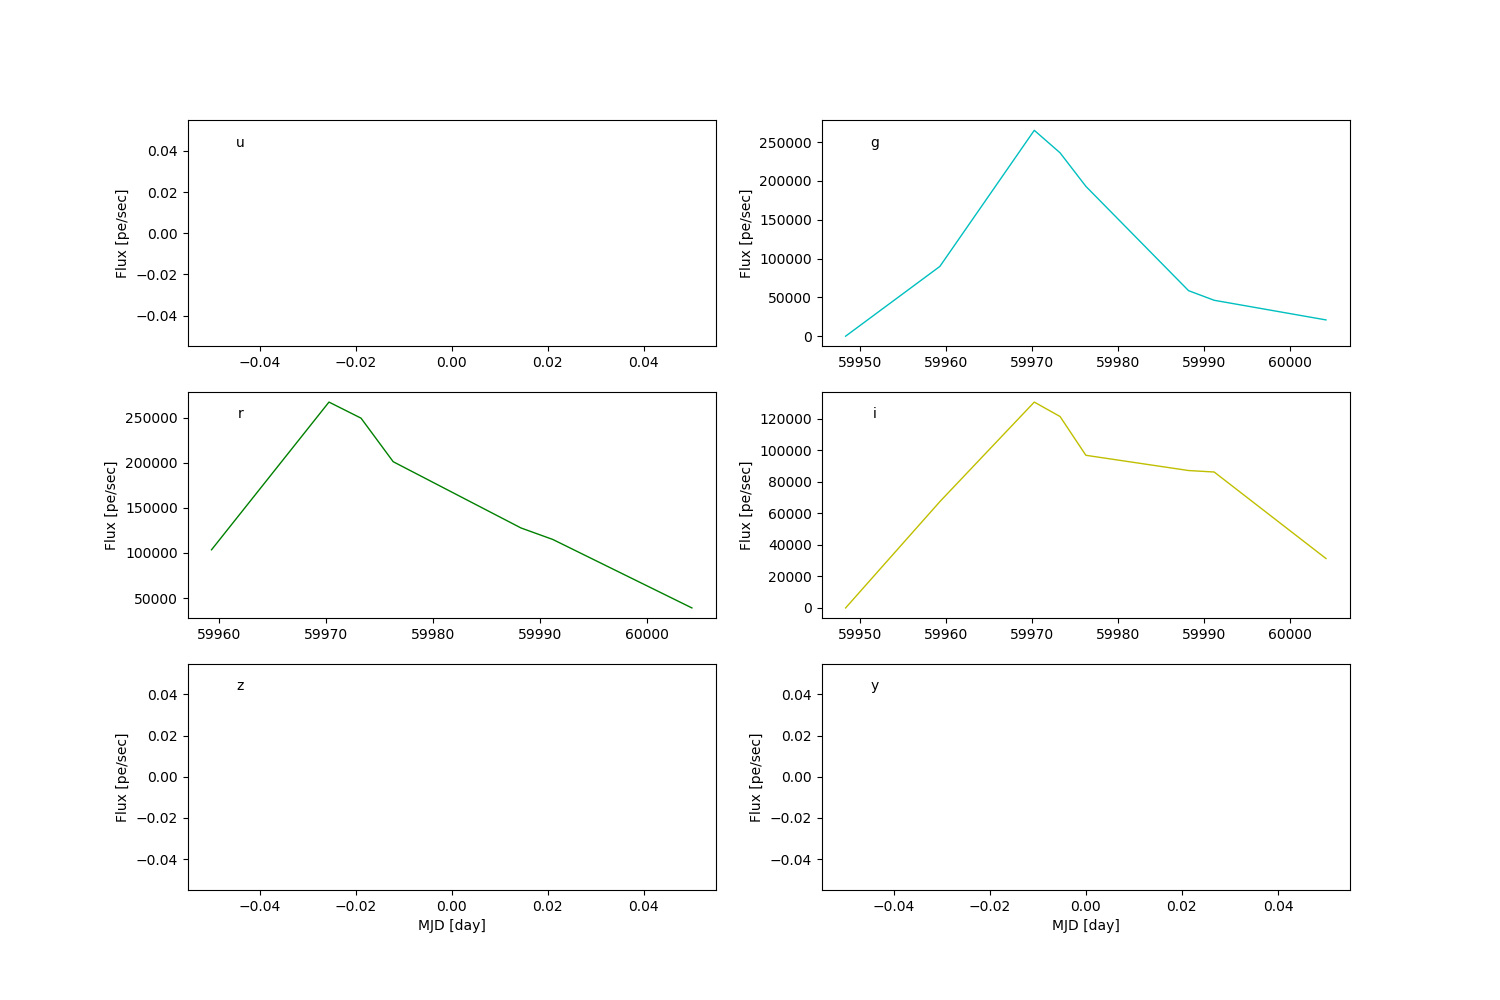

OrderedDict([('Dec', 2.8364990000000003),
             ('Ra', 150.36235499999995),
             ('SNID', 201),
             ('color', 0.2),
             ('daymax', 59968.51957175926),
             ('epsilon_color', 0.0),
             ('epsilon_x0', 0.0),
             ('epsilon_x1', 0.0),
             ('index_hdf5', 101),
             ('survey_area', 9.6),
             ('x0', 0.019793133994619887),
             ('x1', -2.0),
             ('z', 0.01)])
         flux                 fluxerr         ...        phase       
---------------------- ---------------------- ... -------------------
 4.110289289841849e-09 2.9696842057274817e-08 ... -19.992459662632363
1.6288799796876894e-08  5.027949412891584e-08 ...  -19.98491932526761
 0.0020688682498783573  2.661196187629067e-07 ...  -9.145970847085925
 0.0015294136484127927 3.0019394156913705e-07 ...  -9.138430509713967
  0.001834098857852674 2.9418697122029007e-07 ...  -9.130890172349213
 0.0053430200105159505  4.226962211653069e-07 ...  1.72

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=3,figsize=(15,10))
bands='ugrizy'
band_id = dict(zip(bands,[(0,0),(0,1),(1,0),(1,1),(2,0),(2,1)]))
colors = dict(zip(bands,'bcgyrm'))
for i, key in enumerate(f.keys()):
    lc = Table.read(lcFile, path=key)
    pprint.pprint(lc.meta) # metadata
    print(lc) # light curve points
    plotLC(lc,ax,band_id,i)
    break